In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import normalize
import SimpleITK as sitk
import numpy as np
import os
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

### Voxel classification under/overestimation confusion matrix

In [46]:
test_or_validation = "test"
# test_or_validation = "validation"

In [47]:
def create_averaged_confusion_matrix(dataset,
                                     output_shape,
                                     include_background_classification=True):
    if dataset not in os.listdir(f"../evaluation/contours_compare_{test_or_validation}"):
        print(f"Data for {dataset} not found")
        return
    
    path_to_evaluation_data = f"../evaluation/contours_compare_{test_or_validation}/{dataset}"
    path_to_ground_truths = f"{path_to_evaluation_data}/ground_truth"
    path_to_model_predictions = f"{path_to_evaluation_data}/model_output"
    path_to_prostate_delineations = f"{path_to_evaluation_data}/downscaled_prostate_delineations"
    
    # (4, 4) if you want to include background classifications and predictions
    output_cm = np.zeros(output_shape)

    if output_cm.shape == (4, 4):
        voxel_labels = [0, 1, 2, 3]
    elif output_cm.shape == (3, 3):
        voxel_labels = [0, 1, 2]
    elif output_cm.shape == (2, 2):
        voxel_labels = [0, 1]
    else:
        print("Gave invalid shape ", output_shape)
        print("Supported = (3, 3) & (4, 4)")
        return

    num_cases = len(os.listdir(path_to_model_predictions))

    print(f"Creating confusion matrix for {dataset}")
    for patient_file in tqdm(os.listdir(path_to_model_predictions)):
        if ".nii.gz" in patient_file:
            # print(patient_file[:10])
            gt = sitk.ReadImage(f"{path_to_ground_truths}/{patient_file}")
            mp = sitk.ReadImage(f"{path_to_model_predictions}/{patient_file}")
            prostate_delin = sitk.ReadImage(f"{path_to_prostate_delineations}/{patient_file}")

            gt = sitk.GetArrayFromImage(gt)
            mp = sitk.GetArrayFromImage(mp)
            prostate_delin = sitk.GetArrayFromImage(prostate_delin)

            gt = gt.flatten()
            mp = mp.flatten()
            prostate_delin = prostate_delin.flatten()

            # Only count voxels in the prostate to prevent bloating of background
            # Use only voxels that are classified as prostate in the prostate delineation
            gt = gt[prostate_delin != 0]
            mp = mp[prostate_delin != 0]

            cm = confusion_matrix(gt, mp, labels = voxel_labels)
            
            output_cm += cm

    print("sum of confusion matrices, voxelwise: \n", output_cm.astype(int))
    print("total number of cases:", num_cases)
    output_cm = output_cm/num_cases

    return output_cm

all_modalities_cm = create_averaged_confusion_matrix("Dataset005_pca", (4, 4))
gg3gg4_combined_cm = create_averaged_confusion_matrix("Dataset006_pca_gg3gg4combined", (3, 3))
cribriform_only_cm = create_averaged_confusion_matrix("Dataset007_pca_cribriform_only", (2, 2))
adc_only_cm = create_averaged_confusion_matrix("Dataset008_pcaadc", (4, 4))
perf_only_cm = create_averaged_confusion_matrix("Dataset009_pcaperf", (4, 4))




Creating confusion matrix for Dataset005_pca


100%|██████████| 53/53 [00:11<00:00,  4.79it/s]


sum of confusion matrices, voxelwise: 
 [[3286242  105097   28823     270]
 [  52578   55078   15298     591]
 [  75697   49637   47388     929]
 [   3687    6357    5392      87]]
total number of cases: 53
Creating confusion matrix for Dataset006_pca_gg3gg4combined


100%|██████████| 53/53 [00:10<00:00,  4.99it/s]


sum of confusion matrices, voxelwise: 
 [[3275583  143222    1627]
 [ 106321  177730   13145]
 [   2165   11480    1878]]
total number of cases: 53
Creating confusion matrix for Dataset007_pca_cribriform_only


100%|██████████| 53/53 [00:11<00:00,  4.74it/s]


sum of confusion matrices, voxelwise: 
 [[3717628       0]
 [  15523       0]]
total number of cases: 53
Creating confusion matrix for Dataset008_pcaadc


100%|██████████| 53/53 [00:11<00:00,  4.70it/s]


sum of confusion matrices, voxelwise: 
 [[3316489   57067   46036     840]
 [  54182   50194   17161    2008]
 [  81484   33510   54502    4155]
 [   3074    7308    4997     144]]
total number of cases: 53
Creating confusion matrix for Dataset009_pcaperf


100%|██████████| 53/53 [00:10<00:00,  5.14it/s]

sum of confusion matrices, voxelwise: 
 [[3333661   35805   49663    1303]
 [  89194   20196   13268     887]
 [  95194   26919   50754     784]
 [   3896     469   10575     583]]
total number of cases: 53


In [48]:
# Foreground/background
# #################################################################
def create_averaged_confusion_matrix_foreground_background(dataset):
    if dataset not in os.listdir(f"../evaluation/contours_compare_{test_or_validation}"):
        print(f"Data for {dataset} not found")
        return

    path_to_evaluation_data = f"../evaluation/contours_compare_{test_or_validation}/{dataset}"
    path_to_ground_truths = f"{path_to_evaluation_data}/ground_truth"
    path_to_model_predictions = f"{path_to_evaluation_data}/model_output"
    path_to_prostate_delineations = f"{path_to_evaluation_data}/downscaled_prostate_delineations"
    
    # output is always of shape (2, 2) as there is only distinguishing between foreground and background
    output_cm = np.zeros((2, 2))

    num_cases = len(os.listdir(path_to_model_predictions))

    print(f"Creating cm for {dataset}")
    for patient_file in tqdm(os.listdir(path_to_model_predictions)):
        if ".nii.gz" in patient_file:
            # print(patient_file[:10])
            gt = sitk.ReadImage(f"{path_to_ground_truths}/{patient_file}")
            mp = sitk.ReadImage(f"{path_to_model_predictions}/{patient_file}")
            prostate_delin = sitk.ReadImage(f"{path_to_prostate_delineations}/{patient_file}")

            gt = sitk.GetArrayFromImage(gt)
            mp = sitk.GetArrayFromImage(mp)
            prostate_delin = sitk.GetArrayFromImage(prostate_delin)
            
            gt = gt.flatten()
            mp = mp.flatten()
            prostate_delin = prostate_delin.flatten()

            # Only count voxels in the prostate to prevent bloating of background
            # Use only voxels that are classified as prostate in the prostate delineation
            gt = gt[prostate_delin != 0]
            mp = mp[prostate_delin != 0]

            # Transform both delineations in to binary ones, distinguishing only
            # between foreground (lesion) and background (no lesion)
            gt = np.where(gt != 0, 1, 0)
            mp = np.where(mp != 0, 1, 0)

            cm = confusion_matrix(gt, mp, labels=[0, 1])
            
            output_cm += cm

    print("total number of cases:", num_cases)
    print("final cm : \n", output_cm)
    output_cm = output_cm/num_cases
    print("final cm averaged over patients: \n", output_cm)
    print()

    return output_cm

all_modalities_cm_foreground_background = create_averaged_confusion_matrix_foreground_background("Dataset005_pca")
gg3gg4_combined_cm_foreground_background = create_averaged_confusion_matrix_foreground_background("Dataset006_pca_gg3gg4combined")
cribriform_only_cm_foreground_background = create_averaged_confusion_matrix_foreground_background("Dataset007_pca_cribriform_only")
adc_only_cm_foreground_background = create_averaged_confusion_matrix_foreground_background("Dataset008_pcaadc")
perf_only_cm_foreground_background = create_averaged_confusion_matrix_foreground_background("Dataset009_pcaperf")

Creating cm for Dataset005_pca


100%|██████████| 53/53 [00:08<00:00,  6.15it/s]


total number of cases: 53
final cm : 
 [[3286242.  134190.]
 [ 131962.  180757.]]
final cm averaged over patients: 
 [[62004.56603774  2531.88679245]
 [ 2489.8490566   3410.50943396]]

Creating cm for Dataset006_pca_gg3gg4combined


100%|██████████| 53/53 [00:08<00:00,  6.35it/s]


total number of cases: 53
final cm : 
 [[3275583.  144849.]
 [ 108486.  204233.]]
final cm averaged over patients: 
 [[61803.45283019  2733.        ]
 [ 2046.90566038  3853.45283019]]

Creating cm for Dataset007_pca_cribriform_only


100%|██████████| 53/53 [00:08<00:00,  6.60it/s]


total number of cases: 53
final cm : 
 [[3717628.       0.]
 [  15523.       0.]]
final cm averaged over patients: 
 [[70143.9245283      0.        ]
 [  292.88679245     0.        ]]

Creating cm for Dataset008_pcaadc


100%|██████████| 53/53 [00:08<00:00,  6.32it/s]


total number of cases: 53
final cm : 
 [[3316489.  103943.]
 [ 138740.  173979.]]
final cm averaged over patients: 
 [[62575.26415094  1961.18867925]
 [ 2617.73584906  3282.62264151]]

Creating cm for Dataset009_pcaperf


100%|██████████| 53/53 [00:08<00:00,  6.23it/s]

total number of cases: 53
final cm : 
 [[3333661.   86771.]
 [ 188284.  124435.]]
final cm averaged over patients: 
 [[62899.26415094  1637.18867925]
 [ 3552.52830189  2347.83018868]]



In [49]:
# Function to row-wise normalize a confusion matrix and return a set of labels suitable for plotting
# The labels, for each cell (equal shape to input cm), are the normalized value and the original (integer) count
def normalize_and_create_annotations(cm):
    normalized_cm = normalize(cm, axis = 1, norm = 'l1').round(3)

    labels = np.empty(cm.shape, dtype = object)

    for i, row in enumerate(cm):
        for j, col in enumerate(cm):
            labels[i, j] = f"{normalized_cm[i][j]}\n ({int(cm[i][j])})"

    return normalized_cm, labels


In [50]:
# cms
all_modalities_cm
gg3gg4_combined_cm
cribriform_only_cm
adc_only_cm
perf_only_cm
all_modalities_cm_foreground_background
gg3gg4_combined_cm_foreground_background
cribriform_only_cm_foreground_background
adc_only_cm_foreground_background
perf_only_cm_foreground_background

array([[62899.26415094,  1637.18867925],
       [ 3552.52830189,  2347.83018868]])

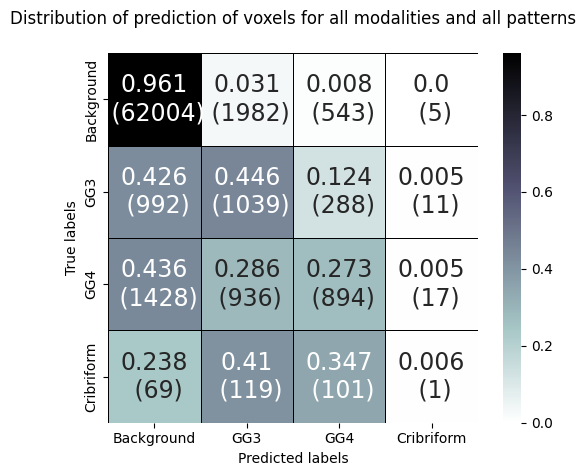

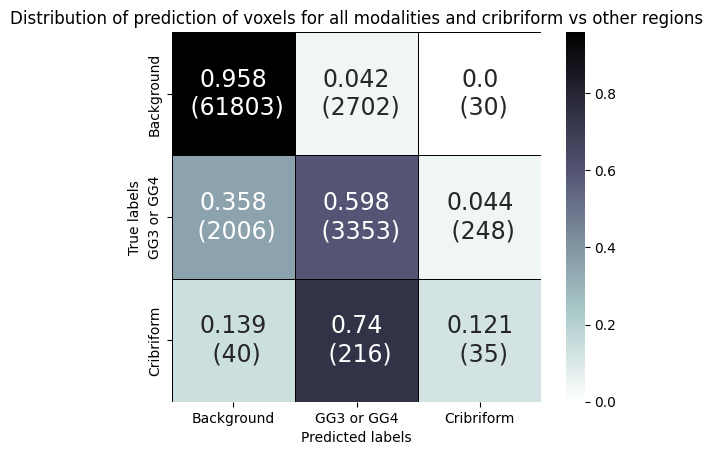

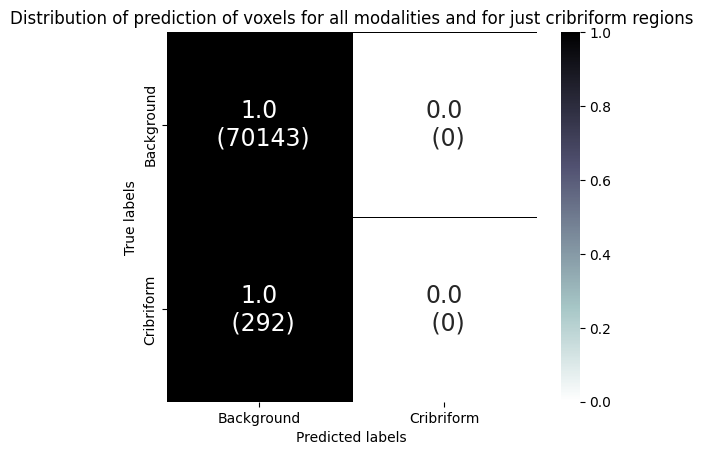

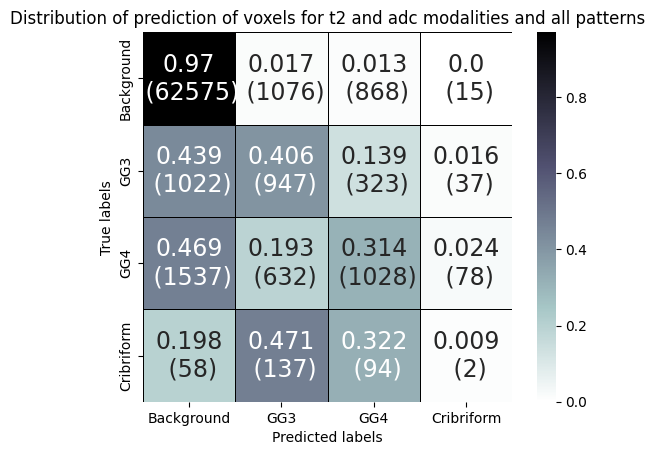

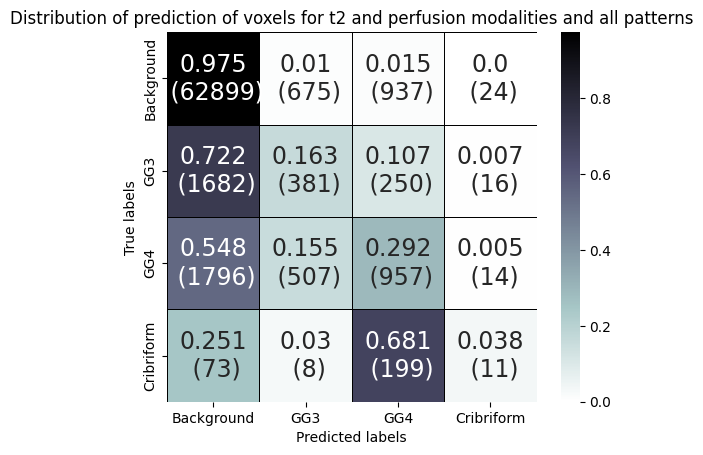

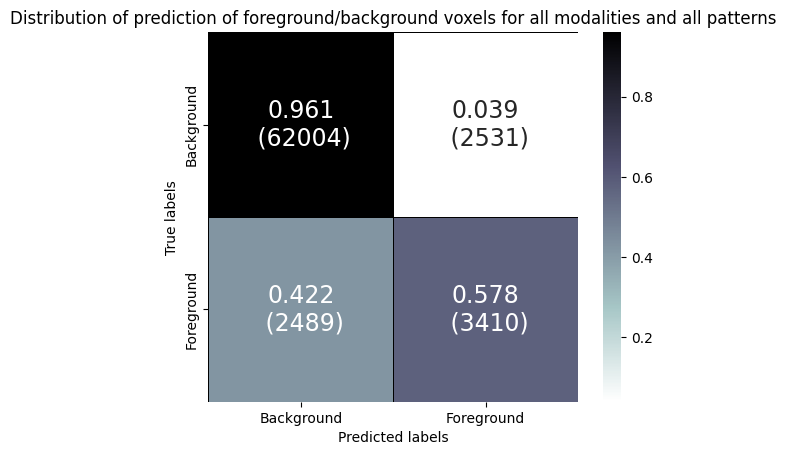

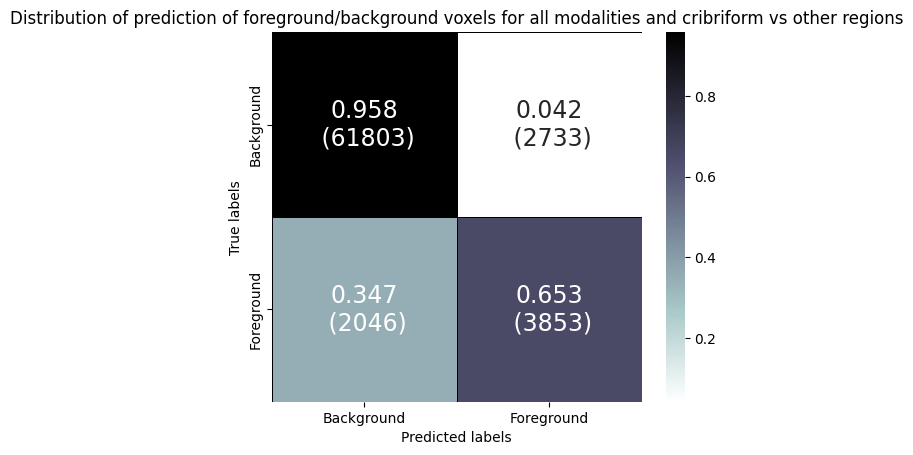

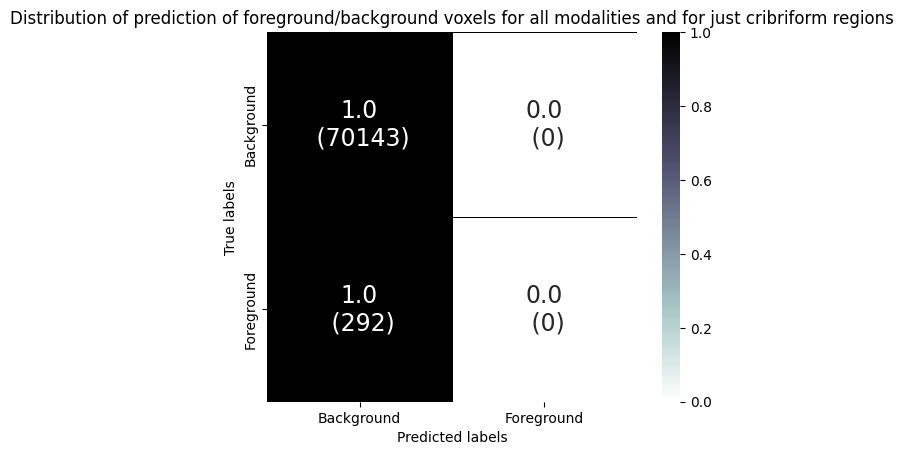

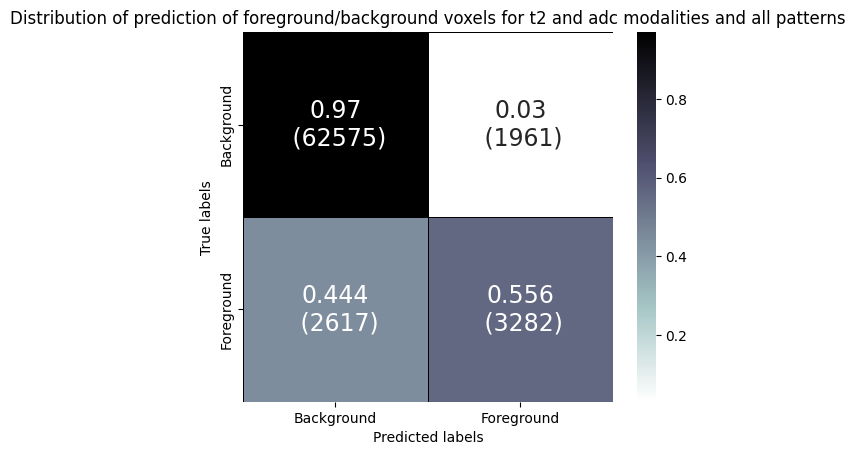

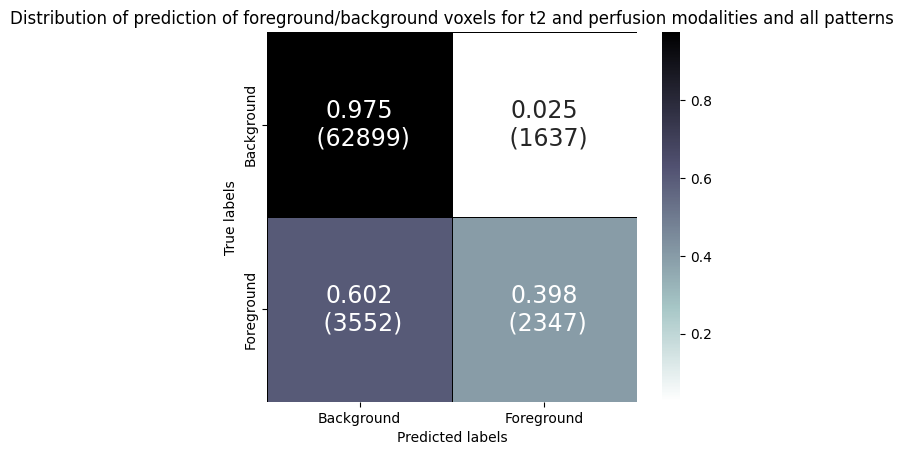

In [51]:
cm_label_tuples = [
    (all_modalities_cm, ["Background", "GG3", "GG4", "Cribriform"],
        "Distribution of prediction of voxels for all modalities and all patterns\n"),
    (gg3gg4_combined_cm, ["Background", "GG3 or GG4", "Cribriform"],
        "Distribution of prediction of voxels for all modalities and cribriform vs other regions"),
    (cribriform_only_cm, ["Background", "Cribriform"],
        "Distribution of prediction of voxels for all modalities and for just cribriform regions"),
    (adc_only_cm, ["Background", "GG3", "GG4", "Cribriform"],
        "Distribution of prediction of voxels for t2 and adc modalities and all patterns"),
    (perf_only_cm, ["Background", "GG3", "GG4", "Cribriform"],
        "Distribution of prediction of voxels for t2 and perfusion modalities and all patterns"),
    (all_modalities_cm_foreground_background, ["Background", "Foreground"],
        "Distribution of prediction of foreground/background voxels for all modalities and all patterns"),
    (gg3gg4_combined_cm_foreground_background, ["Background", "Foreground"],
        "Distribution of prediction of foreground/background voxels for all modalities and cribriform vs other regions"),
    (cribriform_only_cm_foreground_background, ["Background", "Foreground"],
        "Distribution of prediction of foreground/background voxels for all modalities and for just cribriform regions"),
    (adc_only_cm_foreground_background, ["Background", "Foreground"],
        "Distribution of prediction of foreground/background voxels for t2 and adc modalities and all patterns"),
    (perf_only_cm_foreground_background, ["Background", "Foreground"],
        "Distribution of prediction of foreground/background voxels for t2 and perfusion modalities and all patterns"),
    
]

for cm, labels, description in cm_label_tuples:
    # print(cm, labels)
    normalized_cm, annotations = normalize_and_create_annotations(cm)
    sns.heatmap(normalized_cm,
                xticklabels = labels,
                yticklabels = labels,
                linewidths = 0.6,
                linecolor = "black",
                annot = annotations,
                annot_kws = {"size": 17},
                fmt = '',
                # cbar = False,
                square = True,
                cmap = "bone_r")

    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title(f"{description}")

    plt.show()

In [52]:
all_modalities_cm_foreground_background
gg3gg4_combined_cm_foreground_background
cribriform_only_cm_foreground_background
adc_only_cm_foreground_background
perf_only_cm_foreground_background

array([[62899.26415094,  1637.18867925],
       [ 3552.52830189,  2347.83018868]])

In [54]:
def f1_score(cm):
    TP, FP, TN, FN = cm[1][1], cm[0][1], cm[0][0], cm[1][0]

    score = 2 * TP / (2 * TP + FP + FN)
    return score

In [53]:
print(all_modalities_cm_foreground_background)
print(adc_only_cm_foreground_background)

[[62004.56603774  2531.88679245]
 [ 2489.8490566   3410.50943396]]
[[62575.26415094  1961.18867925]
 [ 2617.73584906  3282.62264151]]


In [57]:
print(f1_score(all_modalities_cm_foreground_background))
print(f1_score(adc_only_cm_foreground_background))
print(f1_score(gg3gg4_combined_cm_foreground_background))

0.5759655613017114
0.5891192788851434
0.617203660919219


Text(0.5, 1.0, 'Dataset005+_pca predicted presence of cribriform vs ground truth')

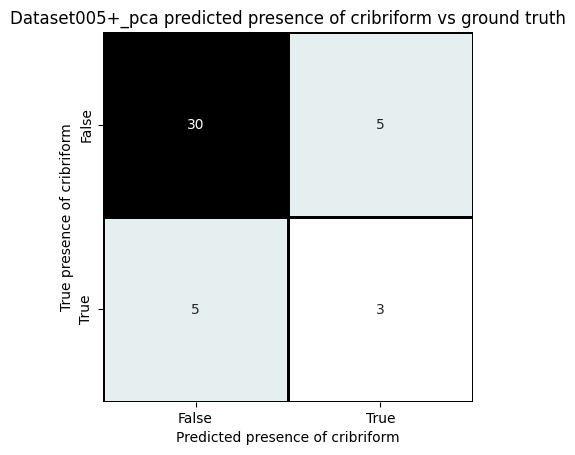

In [10]:
dataset = "Dataset005_pca"

cm_cribriform = [[30, 5],
                 [5, 3]]

sns.heatmap(cm_cribriform,
            xticklabels = ["False", "True"],
            yticklabels = ["False", "True"],
            annot = cm_cribriform,
            linewidths = 1,
            linecolor = "black",
            # annot = True,
            # fmt = '',
            cbar = False,
            square = True,
            cmap = "bone_r")


plt.xlabel("Predicted presence of cribriform")
plt.ylabel("True presence of cribriform")
plt.title(f"{dataset} predicted presence of cribriform vs ground truth")